In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Overfitting and Regularization

"*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk*" (John von Newmann)

**Table of Contents**

- [Overfitting](#1.-Overfitting)
- [Regularization](#2.-Regularization)

## 1. Overfitting

A common danger in machine learning is **overfitting**--producing a model that performs well on the data you train it on but generalizes poorly to any new data. Models that are too complex lead to overfitting and don't generalize well beyond the data they were trained on.

Let's look at an example. First, let's generate some nonlinear data, based on $y = 5x\sin(20x)$.

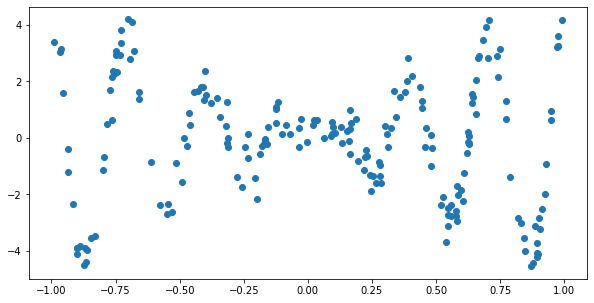

In [10]:
# generate some (toy) data based on y = 5x sin(20x)
m = 200 # number of points
x = -1 + 2*np.random.rand(m) # evenly spaced points on [-1,1]
y = 5*x*np.sin(20*x) + 0.5*np.random.randn(m)

plt.figure(figsize=(10,5))
plt.scatter(x,y)

Let us split the dataset, so that three quarters of it is used to train the model, after which we measure the model's performance on the remaining quarter.

In [11]:
x_train, y_train = x[0:150], y[0:150] # first 3/4
x_test, y_test = x[150:m], y[150:m] # last 1/4

Let's fit degree-d polynomials to the data

$$
y = \theta_0 + \theta_1x+\theta_2x^2 + \cdots + \theta_d x^d
$$

If we perform high-degree polynomial regression, we will likely fit the training data much better than with linear regression.

In [12]:
def build_poly_features(X,degree):
    from itertools import combinations_with_replacement as comb_w_r
    from itertools import chain
    
    # number of datapoints (rows), number of features (columns)
    try:
        m,n = X.shape # this won't work if X is a vector (n=1)
    except: 
        m = len(X)
        n = 1
        X = X.reshape(m,1) #  
    
    # number of polynomial features
    combinations = chain.from_iterable(comb_w_r(range(n),i) for i in range(degree+1))
    n_poly = sum(1 for combination in combinations) 
    
    # polynomial features matrix
    X_poly = np.ones((m,n_poly))
    combinations = chain.from_iterable(comb_w_r(range(n),i) for i in range(degree+1))\
    
    
    for column_index, combination in enumerate(combinations):
        X_poly[:,column_index] = np.prod(X[:,combination],axis=1)
        
    return X_poly

Training Set Mean Squared Error: 0.15857105880733266
Testing Set Mean Squared Error: 546800017267451.7


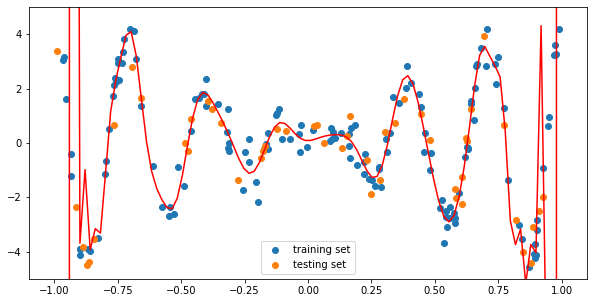

In [34]:
# degree
d = 200 # we'll try 1 (underfitting), 20 (good) and 200 (overfitting)

# feature matrix
X_train_poly = build_poly_features(x_train,degree=d)
X_test_poly = build_poly_features(x_test,degree=d)
    
# solve least squares problem
theta = np.linalg.lstsq(X_train_poly,y_train,rcond=None)[0]

# plot datapoints 
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train, label='training set')
plt.scatter(x_test,y_test, label='testing set')
plt.ylim([-5,5])
plt.legend()

# plot fitted model   
m_plot = 100  
x_plot = np.linspace(-1,1,m_plot) 
X_plot_poly = build_poly_features(x_plot,degree=d)
y_plot = X_plot_poly.dot(theta)
plt.plot(x_plot,y_plot,'r',label='fitted model')

# mean squared errors
y_train_pred = X_train_poly.dot(theta)
y_test_pred = X_test_poly.dot(theta)
mse_train = np.mean((y_train-y_train_pred)**2)
mse_test = np.mean((y_test-y_test_pred)**2)

print('Training Set Mean Squared Error: '+str(mse_train))
print('Testing Set Mean Squared Error: '+str(mse_test))

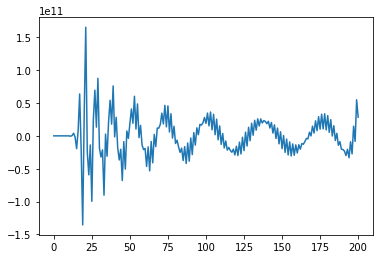

In [40]:
# usually: overfitting -> large coefficients
plt.plot(theta)

In [ ]:
# 1e11 = 10^11

The degree-200 polynomial regression model is overfitting the training data, while the linear model (degree 1) is underfitting it. 
The model that will generalize best in this case is the degree-20 model.

How can we tell that our model is overfitting or underfitting the data? One way is to look at the training and test mean squared errors as a function of the degree. 

Text(0, 0.5, 'mean squared error')

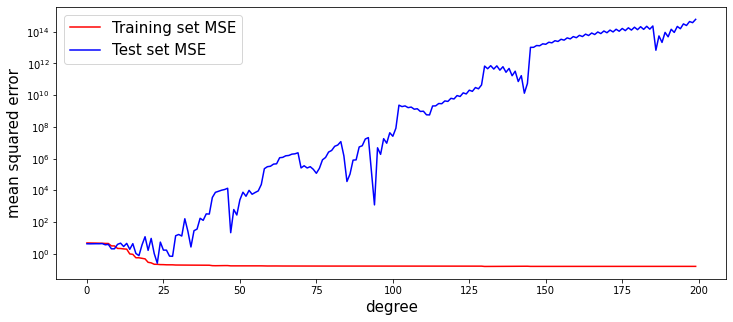

In [14]:
max_degree = 200
# initialize MSE vectors
mse_test = np.zeros(max_degree)
mse_train = np.zeros(max_degree)
# loop over degrees
for d in range(max_degree): # d = 0, 1, 2, ..., max_degree-1
    # feature matrix
    X_train_poly = build_poly_features(x_train,degree=d)
    X_test_poly = build_poly_features(x_test,degree=d)
    
    # solve least squares problem
    theta = np.linalg.lstsq(X_train_poly,y_train,rcond=None)[0]
    
    # mean squared errors
    y_train_pred = X_train_poly.dot(theta)
    y_test_pred = X_test_poly.dot(theta)
    mse_train[d] = np.mean((y_train-y_train_pred)**2)
    mse_test[d] = np.mean((y_test-y_test_pred)**2)
    
    
# plot results
plt.figure(figsize=(12,5))
plt.semilogy(mse_train,'r-',label='Training set MSE') #semilogarithmic plot
plt.semilogy(mse_test,'b-',label='Test set MSE')
plt.legend(fontsize = 15)
plt.xlabel('degree', fontsize=15)
plt.ylabel('mean squared error', fontsize=15)

## 2. Regularization

A good way to reduce overfitting is to regularize our model (i.e., to constrain it).
A simple way to regularize a polynomial model is to reduce its degree.
Another way is to constrain the size of its coefficients.

We add a regularization term to the mean squared error:

$$
E(\theta) = \mbox{MSE}(\theta) + \frac{C}{m}\cdot\|\theta\|^2 = \frac{1}{m}\|y-X\theta\|^2 + \frac{C}{m}\cdot\|\theta\|^2.
$$

The regularization term

$$
\frac{C}{m}\cdot\|\theta\|^2
$$

will penalize vectors $\theta$ with large entries.
The parameter $C$ (known as the regularization constant) controls how much you want to regularize the model. 
If $C=0$ then we are just doing regression.

The vector $\theta$ that minimizes $E(\theta)$ satisfies the system of linear equations

$$
(X^TX + C I_n)\theta = X^T y
$$

Training Set Mean Squared Error: 1.3410517224234686
Testing Set Mean Squared Error: 1.9510455749065505


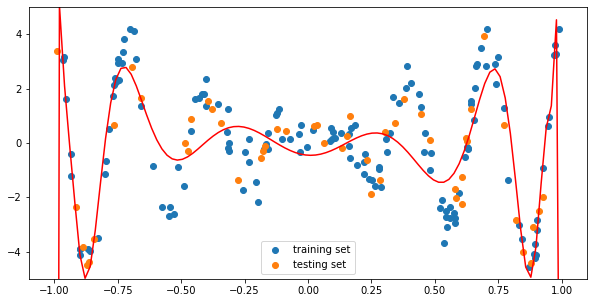

In [33]:
d = 100 # degree
C = 1e-5 # regularization constant


# feature matrices
X_train_poly = build_poly_features(x_train,degree=d)
X_test_poly = build_poly_features(x_test,degree=d)
    
# solve regularized least squares problem'
theta = np.linalg.solve(X_train_poly.T.dot(X_train_poly)+C*np.identity(d+1), X_train_poly.T.dot(y_train))

# plot datapoints 
plt.figure(figsize=(10,5))
plt.scatter(x_train,y_train, label='training set')
plt.scatter(x_test,y_test, label='testing set')
plt.ylim([-5,5])
plt.legend()

# plot fitted model   
m_plot = 100  
x_plot = np.linspace(-1,1,m_plot) 
X_plot_poly = build_poly_features(x_plot,degree=d)
y_plot = X_plot_poly.dot(theta)
plt.plot(x_plot,y_plot,'r',label='fitted model')

# mean squared errors
y_train_pred = X_train_poly.dot(theta)
y_test_pred = X_test_poly.dot(theta)
mse_train = np.mean((y_train-y_train_pred)**2)
mse_test = np.mean((y_test-y_test_pred)**2)

print('Training Set Mean Squared Error: '+str(mse_train))
print('Testing Set Mean Squared Error: '+str(mse_test))

We can plot the training and test mean squared errors as a function of the regularization constant $C$.

Text(0.5, 0, 'regularization constant')

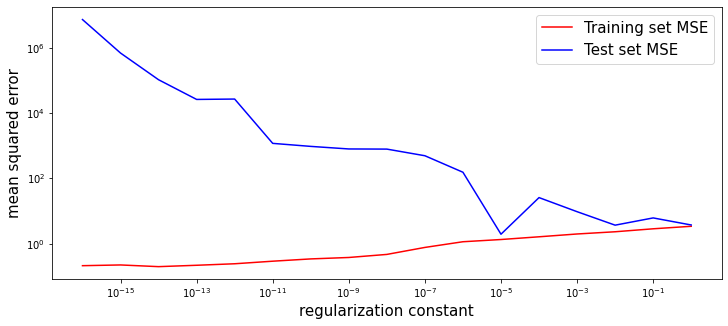

In [32]:
degree = 100
C_list = 10.0**(np.arange(-16,1)) # regularization constants

# initialize mse vectors
mse_test = np.zeros(len(C_list))
mse_train = np.zeros(len(C_list))
for i,C in enumerate(C_list): #(0,1e-16), (1,1e-15), (2,1e-14), ...
    # build feature matrices
    X_train_poly = build_poly_features(x_train,degree=d)
    X_test_poly = build_poly_features(x_test,degree=d)

    # solve regularized least squares problem'
    theta = np.linalg.solve(X_train_poly.T.dot(X_train_poly)+C*np.identity(d+1), X_train_poly.T.dot(y_train))
    
    # mean squared errors
    y_train_pred = X_train_poly.dot(theta)
    y_test_pred = X_test_poly.dot(theta)
    mse_train[i] = np.mean((y_train-y_train_pred)**2)
    mse_test[i] = np.mean((y_test-y_test_pred)**2)

'plot results'
plt.figure(figsize=(12,5))
plt.loglog(C_list,mse_train,'r-',label='Training set MSE') 
plt.loglog(C_list,mse_test,'b-',label='Test set MSE')
plt.legend(fontsize = 15)
plt.ylabel('mean squared error', fontsize=15)
plt.xlabel('regularization constant', fontsize=15)